## Notebook for Pre-processing

In [1]:
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
df = spark.read.parquet("gs://dsa5208-mllib-proj/processed/df_cleaned.parquet")

In [3]:
df.show(10, truncate=False)
df.count()

+-------+--------+---------+---------+-------+-------+---------+--------+----------+------------+
|tmp_cel|latitude|longitude|elevation|dew_cel|slp_hpa|wnd_speed|vis_dist|cig_height|date_numeric|
+-------+--------+---------+---------+-------+-------+---------+--------+----------+------------+
|7.4    |53.25   |4.9166667|5.0      |5.9    |992.0  |90.0     |13000.0 |780.0     |19723.0     |
|7.9    |53.25   |4.9166667|5.0      |4.9    |992.1  |110.0    |24000.0 |1440.0    |19723.0     |
|7.2    |53.25   |4.9166667|5.0      |5.9    |992.6  |70.0     |18000.0 |900.0     |19723.0     |
|8.1    |53.25   |4.9166667|5.0      |6.2    |992.5  |110.0    |15000.0 |1110.0    |19723.0     |
|7.9    |53.25   |4.9166667|5.0      |6.1    |992.8  |130.0    |6000.0  |1170.0    |19723.0     |
|8.3    |53.25   |4.9166667|5.0      |6.3    |993.0  |120.0    |6000.0  |900.0     |19723.0     |
|7.5    |53.25   |4.9166667|5.0      |5.8    |993.7  |110.0    |10000.0 |690.0     |19723.0     |
|8.2    |53.25   |4.

17953096

In [4]:
spark.sparkContext.setCheckpointDir("gs://dsa5208-mllib-proj/rf/spark_checkpoints/")

TARGET_COL = "tmp_cel"
FEATURE_COLS = [
    "latitude","longitude","elevation",
    "dew_cel","slp_hpa","wnd_speed","vis_dist","cig_height",
    "date_numeric"]

# Split the dataset into test and training
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# --- stages ---
imp_cols = [f"{c}__imp" for c in FEATURE_COLS]
imputer = Imputer(inputCols=FEATURE_COLS, outputCols=imp_cols, strategy="mean")

vectorAssembler = VectorAssembler(inputCols=imp_cols, outputCol="features")
rf = RandomForestRegressor(labelCol=TARGET_COL, featuresCol="features", seed=42)
pipeline = Pipeline(stages=[imputer, vectorAssembler, rf])

In [5]:
paramGrid = (ParamGridBuilder()
    .addGrid(rf.maxDepth, [5, 10])
    .addGrid(rf.numTrees, [5, 10, 15])
    .addGrid(rf.minInstancesPerNode, [1, 2])
    .addGrid(rf.subsamplingRate, [0.6, 0.8])
    .addGrid(rf.featureSubsetStrategy, ["sqrt"])
    .build())

In [6]:
# evaluator
rmse_evaluator = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="mae")

# validation split (80/20 inside training)
tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=rmse_evaluator,
    trainRatio=0.8,
)

In [7]:
# fit tuned model on TRAIN
tuned_model = tvs.fit(train_df)

# best parameters
best_model = tuned_model.bestModel

25/11/04 13:38:12 WARN BlockManager: Asked to remove block broadcast_24_piece0, which does not exist
25/11/04 13:44:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_759_11 !
25/11/04 13:44:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_68_20 !
25/11/04 13:44:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_17_19 !
25/11/04 13:44:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_68_2 !
25/11/04 13:44:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_759_2 !
25/11/04 13:44:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_17_2 !
25/11/04 13:44:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_68_10 !
25/11/04 13:44:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_17_11 !
25/11/04 13:44:28 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_759_19 !
25/11/04 13:44:28 WARN YarnAllocator: Container from 

25/11/04 13:52:33 WARN DAGScheduler: Broadcasting large task binary with size 1297.2 KiB
25/11/04 13:54:10 WARN DAGScheduler: Broadcasting large task binary with size 1297.4 KiB
25/11/04 13:54:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/11/04 13:55:40 WARN DAGScheduler: Broadcasting large task binary with size 1297.2 KiB
25/11/04 13:55:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/11/04 13:57:11 WARN DAGScheduler: Broadcasting large task binary with size 1297.5 KiB
25/11/04 13:57:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/11/04 13:59:41 WARN DAGScheduler: Broadcasting large task binary with size 1286.0 KiB
25/11/04 13:59:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [8]:
# evaluate on TEST 
train_preds = best_model.transform(train_df)
test_preds = best_model.transform(test_df)

rmse_test = rmse_evaluator.evaluate(test_preds)
r2_test = r2_evaluator.evaluate(test_preds)
mae_test = mae_evaluator.evaluate(test_preds)

rmse_train = rmse_evaluator.evaluate(train_preds)
r2_train = r2_evaluator.evaluate(train_preds)
mae_train = mae_evaluator.evaluate(train_preds)

In [9]:
print(f"Best Model Test RMSE: {rmse_test:.4f} | R2: {r2_test:.4f} | MAE: {mae_test:.4f}")
print(f"Best Model Train RMSE: {rmse_train:.4f} | R2: {r2_train:.4f} | MAE: {mae_train:.4f}")
print("Best Params:")
for p, v in tuned_model.getEstimatorParamMaps()[tuned_model.validationMetrics.index(min(tuned_model.validationMetrics))].items():
    print(f"  {p.name}: {v}")

Best Model Test RMSE: 4.0314 | R2: 0.8969 | MAE: 2.9460
Best Model Train RMSE: 4.0304 | R2: 0.8971 | MAE: 2.9451
Best Params:
  maxDepth: 10
  numTrees: 15
  minInstancesPerNode: 2
  subsamplingRate: 0.6
  featureSubsetStrategy: sqrt


In [10]:
residuals = test_preds.withColumn("error", F.col("prediction") - F.col(TARGET_COL))
residuals.select(
    F.mean("error").alias("mean_error"),
    F.stddev("error").alias("std_error"),
    F.min("error").alias("min_error"),
    F.max("error").alias("max_error")
).show()

+--------------------+------------------+------------------+-----------------+
|          mean_error|         std_error|         min_error|        max_error|
+--------------------+------------------+------------------+-----------------+
|-0.00283611366076...|4.0313968639683155|-35.56063877842551|47.42794611543678|
+--------------------+------------------+------------------+-----------------+



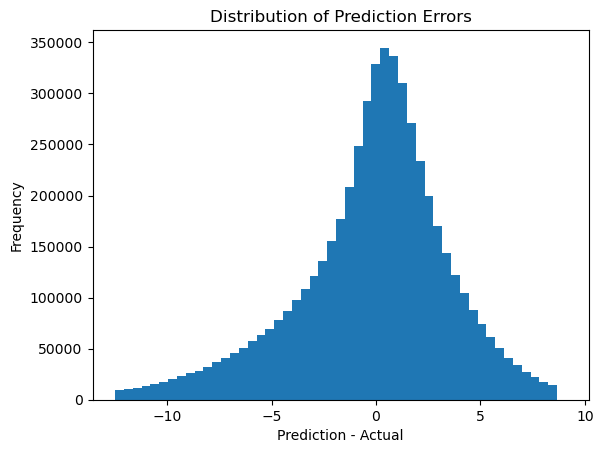

In [12]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Choose bin edges once (e.g., via quantiles to avoid extreme outliers)
q = residuals.approxQuantile("error", [0.01, 0.99], 0.001)
lo, hi = q[0], q[1]
bins = 50
width = (hi - lo) / bins

hist = (residuals
        .where((F.col("error") >= lo) & (F.col("error") <= hi))
        .withColumn("bin", F.floor((F.col("error") - F.lit(lo)) / F.lit(width)))
        .groupBy("bin").agg(F.count("*").alias("cnt"))
        .orderBy("bin"))

# Collect only small bin-count table
hist_pdf = hist.toPandas()

plt.bar(hist_pdf["bin"] * width + lo, hist_pdf["cnt"], width=width)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction - Actual")
plt.ylabel("Frequency")
plt.show()

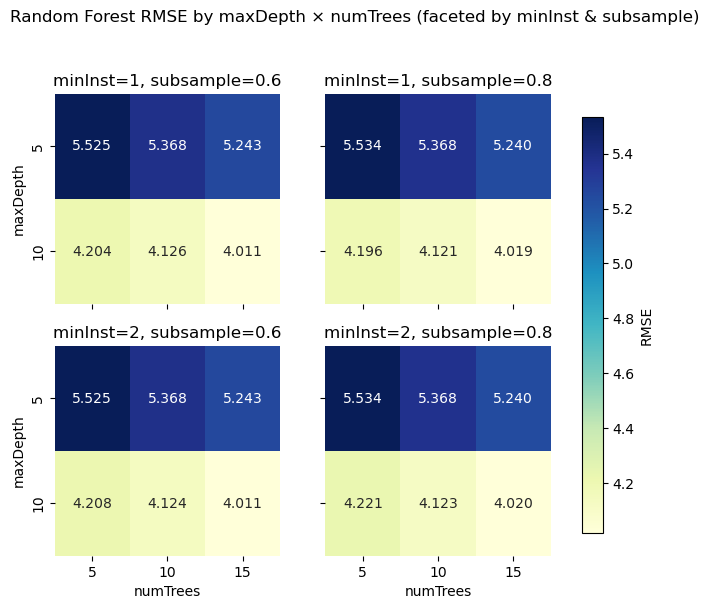

In [13]:
metrics = tuned_model.validationMetrics
params = tuned_model.getEstimatorParamMaps()

rows = []

for m, p in zip(metrics, params):
    rows.append({
        "rmse": m,
        "maxDepth": p[rf.maxDepth],
        "numTrees": p[rf.numTrees],
        "minInstancesPerNode": p[rf.minInstancesPerNode],
        "subSamplingRate": p[rf.subsamplingRate],
    })
    
df2 = pd.DataFrame(rows)
rvals = sorted(df2["minInstancesPerNode"].unique())
cvals = sorted(df2["subSamplingRate"].unique())

fig, axes = plt.subplots(len(rvals), len(cvals), figsize=(4*len(cvals), 3*len(rvals)), sharex=True, sharey=True)

# if there's only one row/col, make axes 2D-like for indexing
if len(rvals) == 1 and len(cvals) == 1:
    axes = np.array([[axes]])
elif len(rvals) == 1:
    axes = axes[np.newaxis, :]
elif len(cvals) == 1:
    axes = axes[:, np.newaxis]

mappable = None
for i, r in enumerate(rvals):
    for j, s in enumerate(cvals):
        ax = axes[i, j]
        sub = df2[(df2["minInstancesPerNode"] == r) & (df2["subSamplingRate"] == s)]
        pivot = sub.pivot(index="maxDepth", columns="numTrees", values="rmse")
        hm = sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f",
                         cbar=False, ax=ax)
        mappable = hm.collections[0]  # keep for a shared colorbar
        ax.set_title(f"minInst={r}, subsample={s:g}")
        ax.set_ylabel("maxDepth" if j == 0 else "")
        ax.set_xlabel("numTrees" if i == len(rvals)-1 else "")

# single shared colorbar
fig.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.9, label="RMSE")
fig.suptitle("Random Forest RMSE by maxDepth × numTrees (faceted by minInst & subsample)", y=1.02)
plt.show()

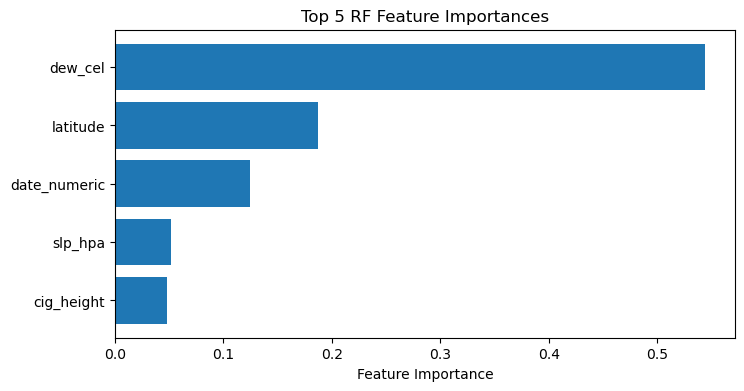

In [14]:
importances = best_model.stages[-1].featureImportances.toArray()

feat_df = pd.DataFrame({
    "feature": FEATURE_COLS,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot top 5
plt.figure(figsize=(8,4))
plt.barh(feat_df["feature"].head(5), feat_df["importance"].head(5))
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 5 RF Feature Importances")
plt.show()